<a href="https://colab.research.google.com/github/DanielIramain/aa-countries/blob/dev/01_Practica2_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Práctica 2
En esta práctica vamos a trabajar con datos socioeconómicos de distintos paises con el objetivo de realizar un análisis de clustering que permita determinar si se pueden establecer grupos de paises a partir de esta clase de datos.

El dataset tendrán que descargarlo del siguiente [link](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data). Luego pueden importarlo a su sesión de Colab directamente desde sus PC locales o ubicarlo en su Drive.

Tienen que probar por lo menos una de las técnicas de clustering vistas en clase, utilizando distintos criterios a la hora generar los clusters. Luego realizar una validación interna de los resultados.

**EXTRA:** En el dataset no hay ninguna variable que agrupe a los paises en distintas categorias que nos permita realizar una validación cruzada. ¿Se les ocurre qué tipo de información externa podría usar para este problema? ¿Se animan a crear una variable de este tipo a partir del criterio elegido?

In [4]:
!pip install kneed

In [5]:
#Librerias generales
import numpy as np
import pandas as pd
from random import sample
from numpy.random import uniform
%matplotlib inline

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#Otros
import scipy.cluster.hierarchy as shc
from yellowbrick.cluster import silhouette_visualizer
from kneed import KneeLocator

In [ ]:
data = pd.read_csv('Country-data.csv')

###Preprocesamiento

For the current 2024 fiscal year, low-income economies are defined as those with a GNI per capita (in dollars), calculated using the World Bank Atlas method, of 1,135 or less in 2022; lower middle-income economies are those with a GNI per capita between 1,136 and 4,465; upper middle-income economies are those with a GNI per capita between 4,466 and 13,845; high-income economies are those with a GNI per capita of 13,846 or more.

Please note: Regions in this table include economies at all income levels. The term country, used interchangeably with economy, does not imply political independence but refers to any territory for which authorities report separate social or economic statistics. Click here for information about how the World Bank classifies countries.

1. low-income = 0
2. lower middle-income = 1
3. upper middle-income = 2
4. high-income = 3

In [7]:
#¿por que tuve que estructurarlo asi?
for i in range(0, len(data['income'] + 1), 1):
  valor = data['income'][i]
  if (valor <= 1135):
    data.at[i, 'class'] = 0
  elif (valor >= 1136) and (valor <= 4465):
    data.at[i, 'class'] = 1
  elif (valor >= 4466) and (valor <= 13845):
    data.at[i, 'class'] = 2
  else:
    data.at[i, 'class'] = 3

In [8]:
#Columna clase en primer lugar (usando list comprehension)
col_comienzo = ['class']
data = data[[c for c in col_comienzo if c in data] + [c for c in data if c not in col_comienzo]]

Veamos la estructura del dataset. Nótese que todas las variables con numéricas continuas, esto nos permite recurrir a distancia euclidean.

In [9]:
data

,class,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,2.0,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,2.0,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,2.0,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,3.0,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...,...
162,1.0,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,3.0,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,2.0,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,2.0,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [10]:
#La cantidad de países y el número de atributos sin contar class que se
#refiere a la clasificación del país según su ingreso per capita
data.shape

(167, 11)

Las diferencias notables entre las medias y desvíos de los atributos entre sí van a representar un problema a la hora de hacer clustering. Por este motivo, una primera aproximación es realizar una estandarización.  

In [11]:
data.describe()

,class,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,2.083832,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,0.914496,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,0.000000,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,1.000000,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,2.000000,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,3.000000,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,3.000000,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [12]:
country_class = data['class']
country_features = data.drop(['class'], axis = 1, inplace = False)

Antes de estandarizar los datos, el método con el que vamos a trabajar no acepta valores tipo string, por lo que dejaremos los nombres de los países en una Serie aparte.

In [13]:
country_names = country_features['country']

In [14]:
country_features.drop(columns='country', inplace=True)

In [15]:
country_features.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [16]:
#Estandarizamos las variables (features) debido a que las diferentes medias y DS
#representarían un problema para nuestro método de clustering
columns_name = country_features.columns

scaler = StandardScaler()
scaled = scaler.fit_transform(country_features)
country_features = pd.DataFrame(scaled, columns = columns_name)

###Veamos el resultado
country_features.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


Ahora la media es un número cercano a 0 y el desvío es un número cercano a 1 con esta estandarización.

In [17]:
###Veamos ahora los estadisticos básicos estandarizados
country_features.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-3.722904e-17,2.127373e-16,5.504579e-16,2.765585e-16,-7.977650e-17,-1.063687e-17,3.696311e-16,3.044803e-16,5.850277e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.871383e-01,-1.500192e+00,-1.827827e+00,-1.939940e+00,-8.603259e-01,-1.137852e+00,-4.337186e+00,-1.191250e+00,-6.968005e-01
25%,-7.466190e-01,-6.333367e-01,-6.922106e-01,-6.914785e-01,-7.174558e-01,-5.666409e-01,-5.927576e-01,-7.639023e-01,-6.366596e-01
50%,-4.717981e-01,-2.235279e-01,-1.810007e-01,-1.487432e-01,-3.738080e-01,-2.269504e-01,2.869576e-01,-3.564309e-01,-4.544309e-01
75%,5.926666e-01,3.747198e-01,6.515412e-01,4.913530e-01,2.942370e-01,2.816364e-01,7.042584e-01,6.175252e-01,5.942100e-02
max,4.221297e+00,5.813835e+00,4.047436e+00,5.266181e+00,5.611542e+00,9.129718e+00,1.380962e+00,3.009349e+00,5.036507e+00


Estadístico de Hopkins: permite evaluar la tendencia de clustering de un conjunto de datos mediante el cálculo de la probabilidad de que dichos datos procedan de una distribución uniforme, es decir, estudia la distribución espacial aleatoria de las observaciones.

Therefore, we can interpret Hopkins' statistic in the following manner:

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.


In [18]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):

    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures


    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))



    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]


    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)

    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour

    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]



    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

Como podemos ver al llamar a la función, pasándole como argumento el dataframe, este estadístico nos devuelve un valor que indica una alta tendencia a formar clusters.

In [19]:
hopkins_statistic(country_features)

0.8892922262608488

In [20]:
#Cómo el valor de este estadístico depende de una comparación con una muestra aleatoria, lo vamos a calcular varias veces y promediar los distintos valores.
#De esta forma obtenemos un valor más consistente
l = []
for i in range(20):
    H=hopkins_statistic(country_features)
    l.append(H)
#Valor del estadístico Hopkins promedio
np.mean(l)

0.8573180690789048

Realizaremos PCA para reducir la dimensionalidad de los datos y también poder graficarlos.

In [21]:
#Realizamos el PCA
pca = PCA(n_components=2) #Vamos a representar nuestros datos en 2 dimensiones
principalComponents = pca.fit_transform(country_features)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, country_class], axis = 1)

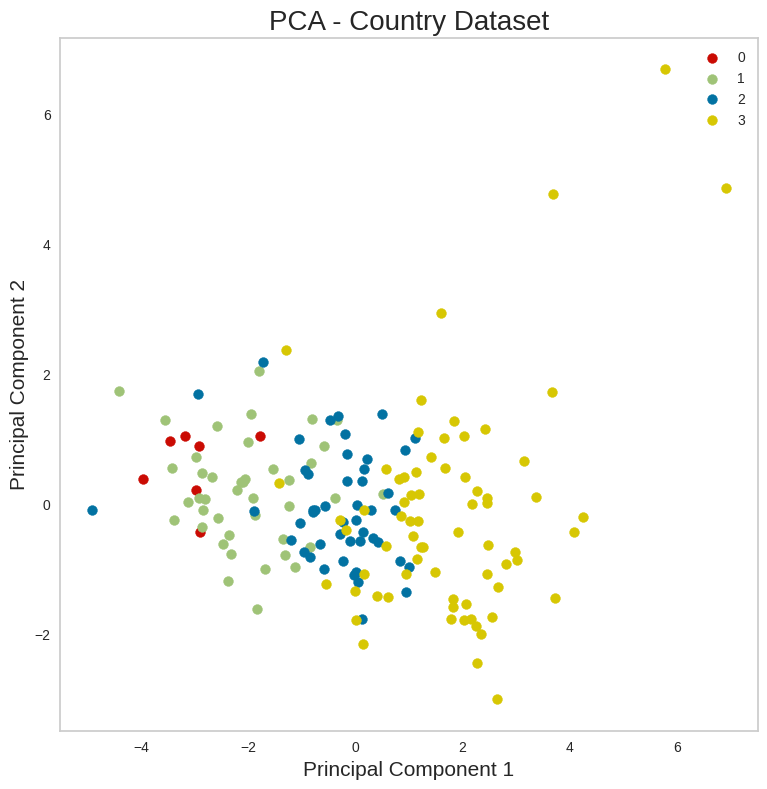

In [22]:
#Graficamos la distribución de nuestros puntos en este nuevo espacio
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Country Dataset', fontsize = 20)

targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###Clustering jerarquico

Grafiquemos algunos dendogramas para elegir el método de cálculo de similitudes entre clusters.

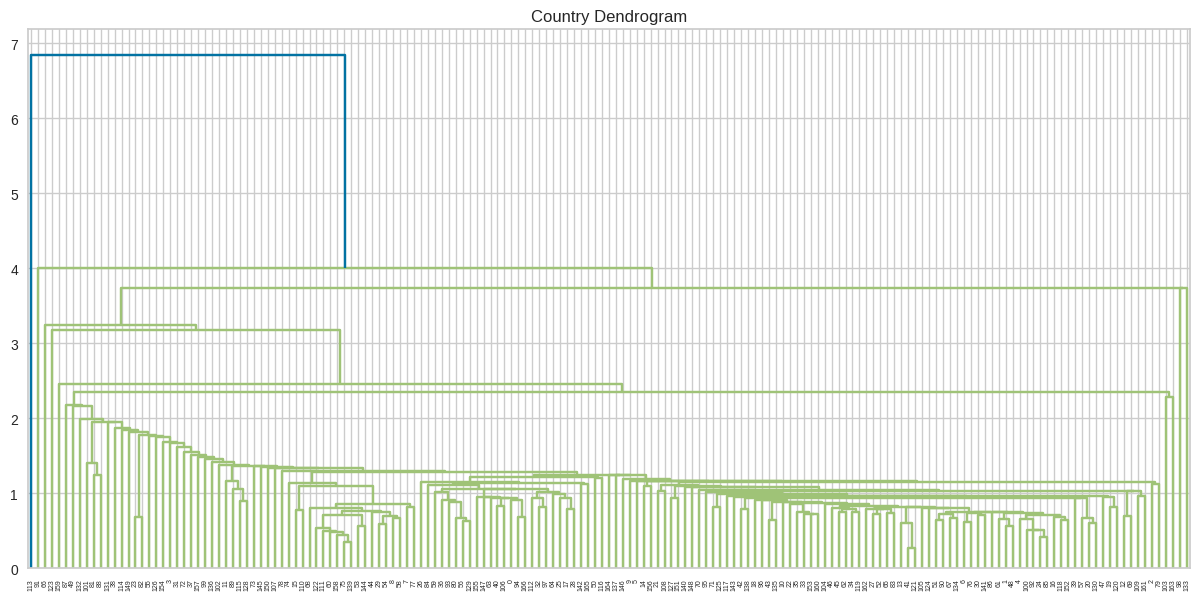

In [23]:
#Single linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram")

#Con la funcion linkage estamos formando y calculando similaridades.
#Con dendrogram vamos a poder visualizarlo.
#El method es el criterio de similaridad, y es lo que iremos cambiando.
clusters = shc.linkage(country_features,
            method='single',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

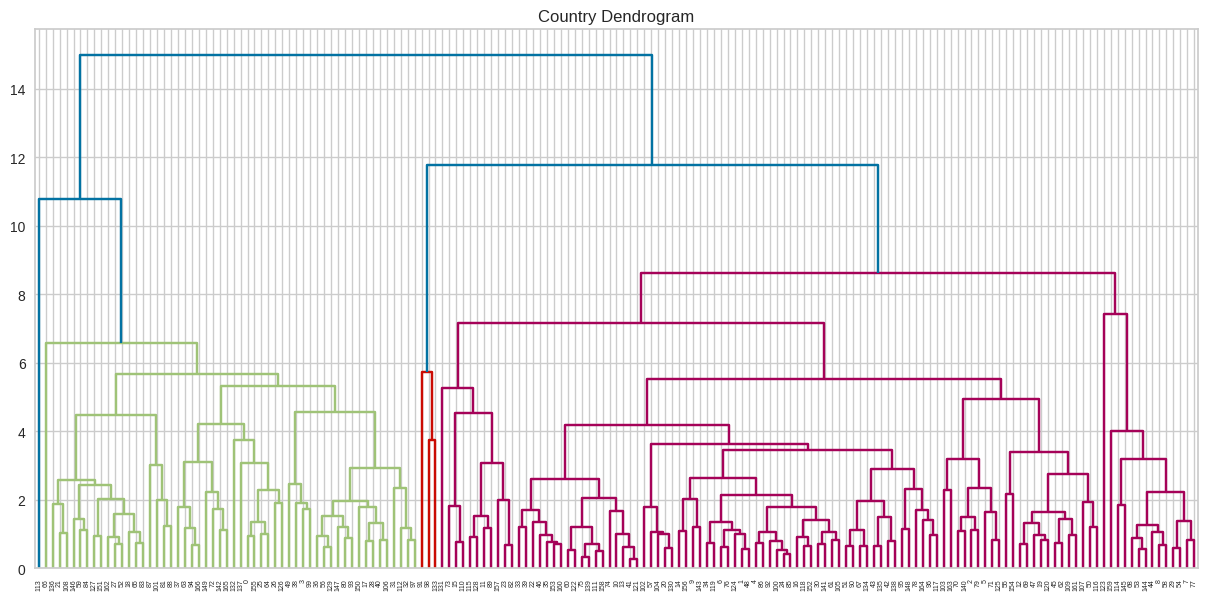

In [24]:
#Complete linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram")

clusters = shc.linkage(country_features,
            method='complete',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

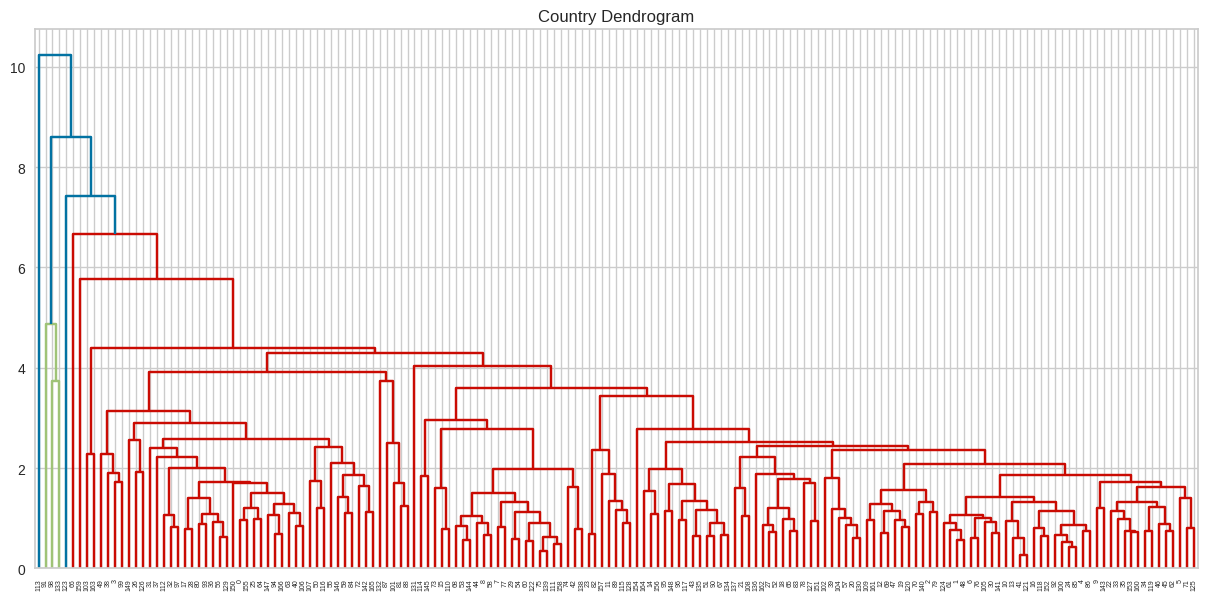

In [25]:
#Average linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram")

clusters = shc.linkage(country_features,
            method='average',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

Utilizaremos el método de Ward porque obtenemos agrupamientos con una buena distancia inter-clusters (se unen bastante arriba en el dendrograma).

**Observacion:** hay cuatro grupos en nuestro dataset, pero este método nos devolvió solo tres.

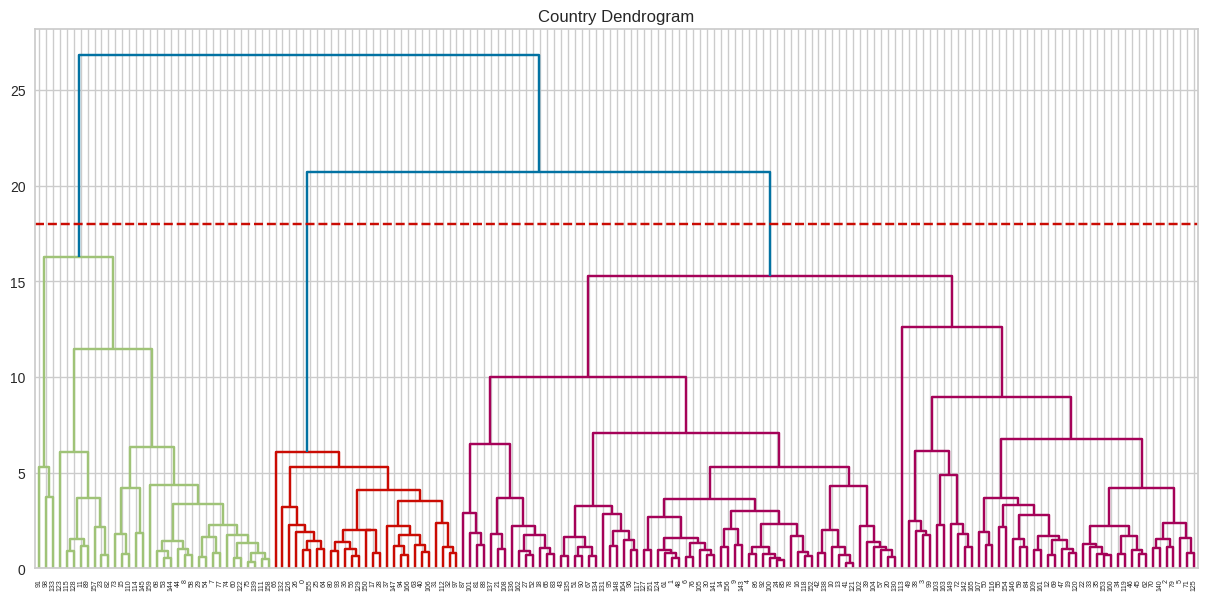

In [26]:
#Ward linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram")

clusters = shc.linkage(country_features,
            method='ward',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.axhline(y = 18, color = 'r', linestyle = '--')
plt.show()

###Clustering jerárquico aglomerativo

In [27]:
#Fijense que ya le estamos diciendo que forme tres grupos, decisión que viene de ver el dendrograma!
#n_clusters define dónde vamos a cortar
clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean',
                                           linkage='ward')
clustering_model.fit(country_features)

#Ver la asignación de las observaciones a los clusters?
clustering_model.labels_

array([2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2])

In [28]:
#Vamos a ir guardando los agrupamientos que formemos con cada uno de los métodos
#en la misma tabla para compararlos al final
finalDf['hclust'] = clustering_model.labels_

Ahora podemos hacer la misma visualización que antes con nuestros datos en espacio de PCA pero los puntos no están pintados por la información externa o etiqueta que tenemos, si no que están pintados por cómo el método los asignó a diferentes clusters.

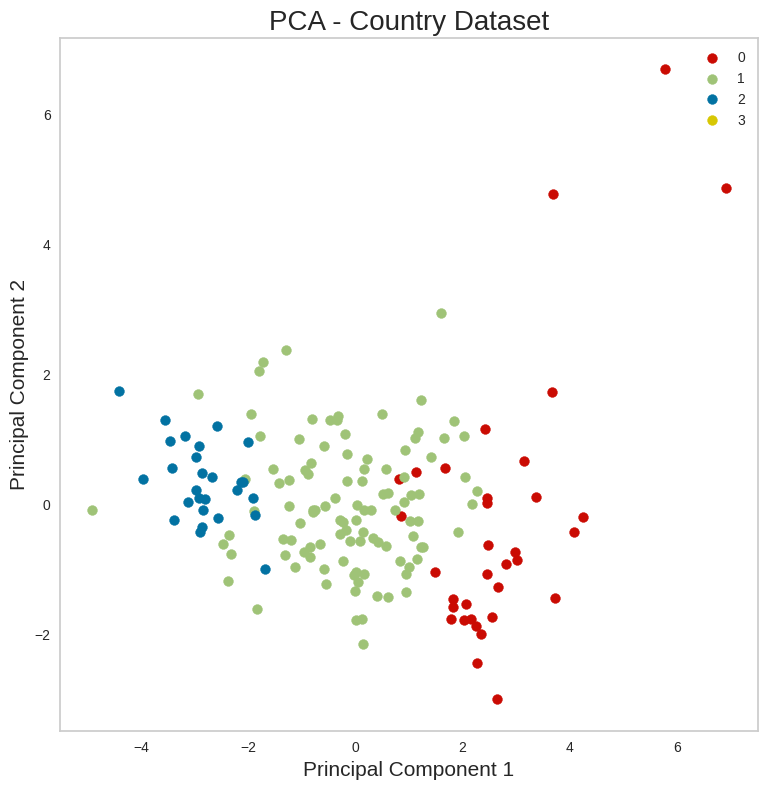

In [29]:
#Graficamos la distribución de nuestros puntos en este nuevo espacio
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Country Dataset', fontsize = 20)

targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['hclust'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###K-Means

In [30]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# SSE: Sum of Square Error
###Hacemos un clustering donde vamos cambiando el valor de k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(country_features)
    #Calculamos la inercia (variabilidad del cluster)
    sse.append(kmeans.inertia_)

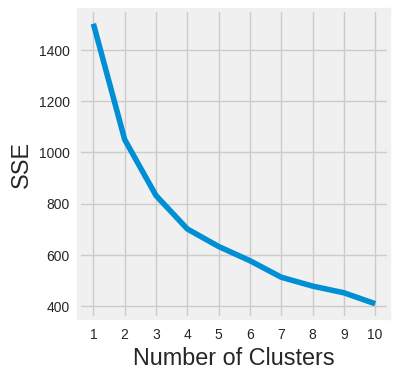

In [31]:
fig = plt.figure(figsize = (4,4))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [32]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

In [35]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [36]:
kmeans.fit(country_features)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [38]:
#¿Donde estan los centroides de los clusters que generó?
###El valor que tiene el centroide para cada atributo (9), y como tenemos 4
###clusters tenemos 4 centroides
kmeans.cluster_centers_

array([[-0.84900324,  4.93567278, -0.00816303,  4.54805768,  2.4395424 ,
        -0.50420614,  1.22682431, -1.03886271,  2.44079735],
       [ 1.34541883, -0.45967186, -0.1895969 , -0.22567743, -0.68713515,
         0.39226703, -1.26429235,  1.32908188, -0.60530769],
       [-0.82787747,  0.16811209,  0.88737767, -0.30560645,  1.48891727,
        -0.47955552,  1.1087252 , -0.75076544,  1.70196967],
       [-0.43706491,  0.02737909, -0.19090588,  0.06955093, -0.20131886,
        -0.03918493,  0.28566125, -0.44720856, -0.31752579]])

In [39]:
#Asignación de las observaciones a cada cluster
kmeans.labels_

array([1, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 1,
       3, 2, 3, 1, 1, 3, 1, 2, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 2, 3,
       2, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 1, 1, 3, 2, 1, 2, 3, 3, 1, 1, 3,
       1, 3, 2, 3, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 1, 3, 3, 1,
       1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3,
       2, 2, 1, 1, 2, 3, 1, 3, 3, 3, 3, 3, 2, 2, 3, 3, 1, 3, 3, 1, 3, 3,
       1, 0, 3, 2, 3, 1, 3, 2, 3, 3, 1, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 3,
       3, 1, 3, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1], dtype=int32)

In [40]:
#Lo agregamos a nuestra tabla comparativa
finalDf['kmeans'] = kmeans.labels_

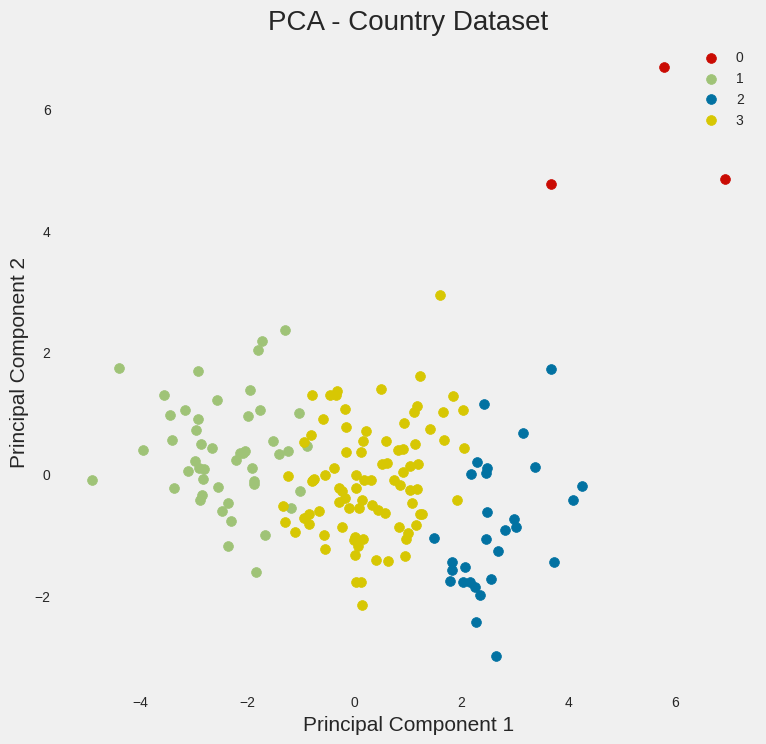

In [41]:
#Cómo se verán nuestros datos?
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Country Dataset', fontsize = 20)
targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['kmeans'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###DBSCAN

In [42]:
#Calcularemos DBSCAN sobre la base de PCA
pca_data = finalDf.loc[:,['principal component 1',	'principal component 2']]

Text(0, 0.5, 'Distance')

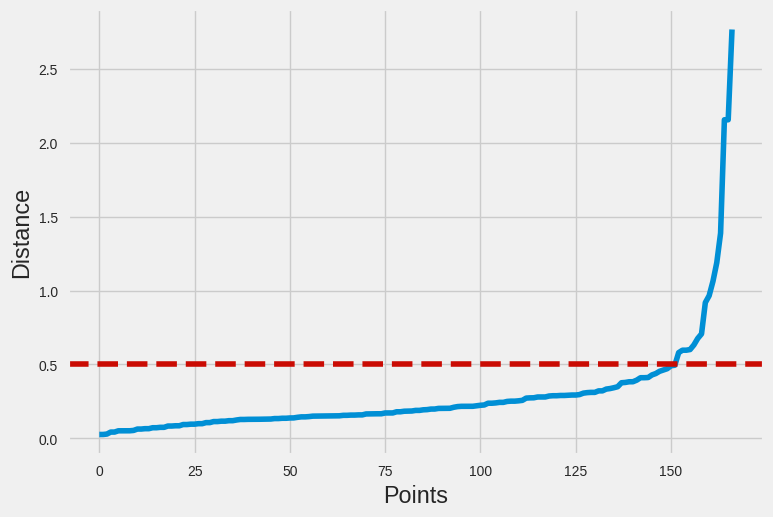

In [44]:
#Ver qué valor de Eps nos puede servir
k = 2
data_nn = pca_data.copy()

# Calculamos los vecinos más cercanos
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data_nn)
distances, indices = neighbors.kneighbors(data_nn)
distances = np.sort(distances, axis=0)

# Obtenemos las distancias
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i,
    y = distances
)
plt.axhline(y = 0.5, color = 'r', linestyle = '--')
plt.xlabel("Points")
plt.ylabel("Distance")

In [45]:
dbscan_clusters = DBSCAN(eps = 0.5, min_samples = 5).fit(pca_data)

In [46]:
#Mostramos las etiquetas asignadas
dbscan_clusters.labels_

array([ 0,  1,  1, -1,  1,  1,  1,  2,  4,  1,  1,  1,  1,  1,  1, -1,  1,
        0,  1,  1,  1,  1,  1,  3,  1,  0,  0,  1,  0,  2,  1, -1,  0,  1,
        1,  1,  0,  0, -1,  1,  0,  1,  3,  3,  4,  1,  1,  1,  1, -1,  0,
        1,  1,  4,  2,  1,  0,  1,  2,  0,  2,  1,  1,  0,  0,  1, -1,  1,
        4,  1,  1,  1,  1, -1,  1,  2,  1,  2,  1,  1,  0,  1,  3,  1,  1,
        1,  1, -1, -1,  1,  1, -1,  1,  0,  0,  1,  1,  0, -1, -1,  1,  1,
        1,  1,  1,  1,  0, -1,  1,  1, -1,  2,  0, -1, -1,  1,  0,  1,  1,
        1,  1,  1,  2, -1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  3,
        1,  1,  3,  2,  1,  1,  0,  1,  4, -1,  1,  0,  1, -1, -1,  1,  1,
        1,  1,  0,  1, -1,  2, -1,  1,  1,  1,  1, -1,  0,  0])

In [47]:
#Agregamos los valores obtenidos a nuestra tabla comparativa
finalDf['dbscan_pca'] = pd.Series(dbscan_clusters.labels_)

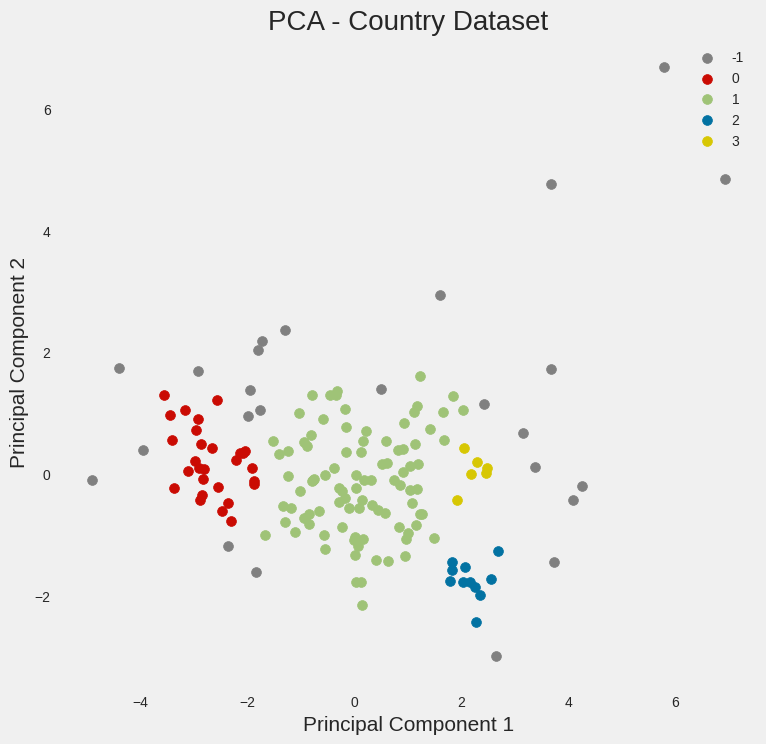

In [48]:
#Mostramos los clusters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Country Dataset', fontsize = 20)
targets = [-1, 0, 1, 2, 3]
colors = ['gray', 'r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['dbscan_pca'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###Comparación de métodos de clustering

####Validación externa

ARI

In [55]:
labels_true = country_class

In [56]:
#Para el clustering jerarquico
adjusted_rand_score(labels_true, finalDf['hclust'])

0.2028435895864485

In [57]:
#Para kmeans
adjusted_rand_score(labels_true, finalDf['kmeans'])

0.22233874189488412

In [58]:
#Para DBSCAN
adjusted_rand_score(labels_true, finalDf['dbscan_pca'])

0.13897243095981643

####Validación Interna

Davies-Bouldin Score

In [59]:
#Clustering Jerarquico
davies_bouldin_score(country_features, finalDf['hclust'])

1.299788958694555

In [60]:
#Kmeans
davies_bouldin_score(country_features, finalDf['kmeans'])

1.0419060938611253

In [62]:
#DBScan
davies_bouldin_score(country_features, finalDf['dbscan_pca'])

2.1880926683328537

Silhoutte Score

In [64]:
#Clustering jerárquico
silhouette_score(country_features, finalDf['hclust'])

0.24563001303300652

In [65]:
silhouette_score(country_features, finalDf['kmeans'])

0.303676957667828

In [66]:
silhouette_score(country_features, finalDf['dbscan_pca'])

0.12212871903531475

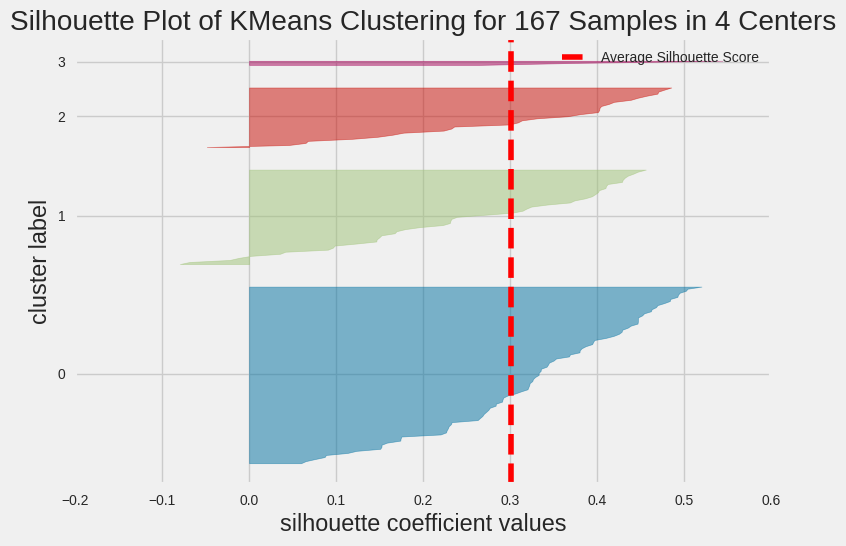

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 167 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, n_init=10, random_state=42))

In [67]:
silhouette_visualizer(KMeans(4, n_init=10, random_state=42), country_features, colors='yellowbrick')

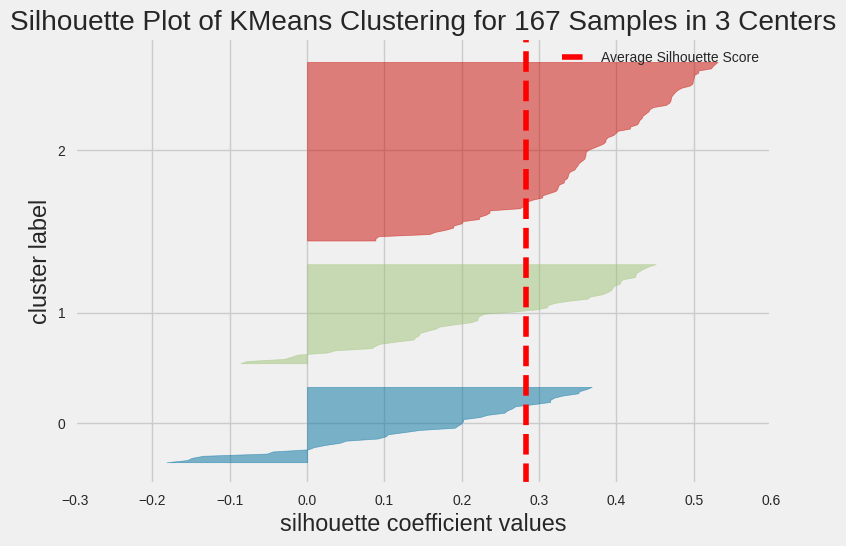

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 167 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [68]:
silhouette_visualizer(KMeans(3, n_init=10, random_state=42), country_features, colors='yellowbrick')